# 9 | Independent Coding: Model-fitting with RANSAC
**ES143 Computer Vision, Harvard University, Fall 2020**

This is an independent coding task. In it you will learn to:
* use RANSAC to robustly fit a line model in the presence of outliers

This notebook requires image `dots_outliers.tif`, which is available on the course website.

## Instructions:
1. Run the notebook and then read Sections 1 and 2.
2. Follow the instructions in Section 3.
3. Submit `.ipynb` and `.html` versions of this notebook to [canvas](https://canvas.harvard.edu/courses/78234/assignments/420410). Submission filenames should be of the form `ransac_lastname_firstname.ipynb` and `ransac_lastname_firstname.html`.

In [3]:
# Import any required libraries here
import cv2                # OpenCV
import numpy as np        # numpy

# Use this line to make plots static and non-interactive
# (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters or use plt.figure(figsize=[H, W]) before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

### 1. Recall: Line fitting with total least squares

The following cell defines clean versions of two functions that you've seen before.
* `line = fitlineTLS(impts)`: Fits line ${\bf l}=(a,b,c)$ to an $N\times 2$ array `impts` of inhomogeneous points $(x,y)$
* `plotimageline(h,w,l,ax)`: Visualizes line ${\bf l}=(a,b,c)$ superimposed on an image with shape $h,w$ in figure axes `ax`

In [4]:
# Usage: plotimageline(h,w,l,ax)
# Input:
#   h,w -- height and width of image (in pixels)
#   l  -- 3-vector of line coordinates (a,b,c) ax+by+c = 0
#   ax -- plt.axes object 
def plotimageline(h,w,line,ax):

    x,y=np.meshgrid(np.linspace(0,w,w*2),np.linspace(0,h,h*2))
    ax.contour(x, y, line[0]*x+line[1]*y+line[2], [0], colors='r')

    return 1

# Usage: line = fitlineTLS(impts)
# Input:
#   impts -- Nx2 array of inhomogeneous image points (x,y) 
# Output:
#   line -- 3-vector of line coordinates (a,b,c)
def fitlineTLS(X):

    # normalize points by subracting mean
    X_norm = X - np.mean(X,axis=0)
    
    # best-fit line (a,b) via SVD (Szeliski Eq. A.44)
    _,_,VT = np.linalg.svd(X_norm)

    # undo normalization
    l = np.append(VT[1,:],-np.dot(VT[1,:],np.mean(X,axis=0)))

    return l

## 2. Impact of outliers

We test the above function using a toy image of points with many outliers. Notice how the least-squares fit is badly affected by the outliers.

1

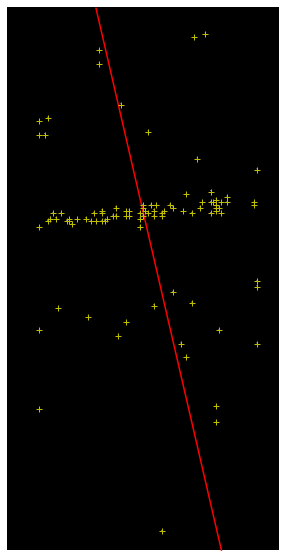

In [5]:
# Load image and convert to grayscale
img = cv2.imread('dots_outliers.tif')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# pixel coordinates of detected points
y, x = np.nonzero(img)  # nonzero() returns row indices followed by column indices

# fit line
l=fitlineTLS(np.vstack((x, y)).T)

# plot image and line
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(img,cmap="gray")
ax.axis('off')

plt.plot(x, y, 'y+')

h,w=img.shape
plotimageline(h,w,l,ax)

## 3. Work Here: Robust fitting with RANSAC

The next cell provides skeleton code for robust fitting with RANSAC. The basic idea is to fit many lines to random pairs of points and then keep the best one. The cell is missing a few lines of code that compute the distances `dist` from all points to each sampled line. (Actually, there is placeholder code there that incorrectly sets all of the distances to a constant value that is less than the inlier threshold.)

### Instructions:
1. Visit [this jamboard](https://jamboard.google.com/d/1Nmb-MNNQ388LsrKmutM3j5fzFT0yt_CeiLePcecMz-k/viewer?f=0) and post at least one question about an element of the following code that you want to understand better. We will discuss these questions and answers as a group before moving on.
2. Write code that replaces the line under `# YOUR CODE HERE #`. Your code should compute an $N$-vector of perpendicular distances between each of the $N$ datapoints and the current iteration's line model.
3. Post a snapshot of your successful fit to [padlet](https://padlet.com/zickler/ransac_lines), with your name in the title and a description of the parameter values that you used.

_Hint:_ The perpendicular distance from a 2D point $(x,y)$ to a line $(a,b,c)$ is 

\begin{equation}
\frac{|ax+by+c|}{\sqrt{a^2+b^2}}
\end{equation}

In [14]:
numpts = x.size
sample_inds = np.random.choice(numpts,size=2,replace=False)
# print(sample_inds)
# np.where(x != x[sample_inds])

print(x[[i for i in range(x.size) if i not in sample_inds]])

print(x)

[291 275 135 135 167  59  47 207  47  55 279 367 299 263 323 307 287 299
 303 315 323 199 211 219 239 307 363 159 199 243 283 307 311 139 175 179
 203 215 231 259 307  67  79 127 139 195 207 227 271 299 315 155 159 175
 179 199 215 227  63  71  91 103 115 147 195  59  87  91 123 131 139 143
  95 195 367 367 243 271 215  75 119 175  47 311 163 255 367 263 307  47
 307 227]
[291 275 135 135 167  59  47 207  47  55 279 367 299 263 323 307 287 299
 303 315 323 363 199 211 219 239 307 363 159 199 243 283 307 311 139 175
 179 203 215 231 259 307  67  79 127 139 195 207 227 271 299 315 155 159
 175 179 199 215 227  63  71  91 103 115 147 195  59  87  91 123 131 139
 143  95  47 195 367 367 243 271 215  75 119 175  47 311 163 255 367 263
 307  47 307 227]


In [16]:
x0y01 = np.stack([x,y, np.ones(len(x))], axis=1)
print(x0y01)

[[291.  39.   1.]
 [275.  43.   1.]
 [135.  63.   1.]
 [135.  83.   1.]
 [167. 143.   1.]
 [ 59. 163.   1.]
 [ 47. 167.   1.]
 [207. 183.   1.]
 [ 47. 187.   1.]
 [ 55. 187.   1.]
 [279. 223.   1.]
 [367. 239.   1.]
 [299. 271.   1.]
 [263. 275.   1.]
 [323. 279.   1.]
 [307. 283.   1.]
 [287. 287.   1.]
 [299. 287.   1.]
 [303. 287.   1.]
 [315. 287.   1.]
 [323. 287.   1.]
 [363. 287.   1.]
 [199. 291.   1.]
 [211. 291.   1.]
 [219. 291.   1.]
 [239. 291.   1.]
 [307. 291.   1.]
 [363. 291.   1.]
 [159. 295.   1.]
 [199. 295.   1.]
 [243. 295.   1.]
 [283. 295.   1.]
 [307. 295.   1.]
 [311. 295.   1.]
 [139. 299.   1.]
 [175. 299.   1.]
 [179. 299.   1.]
 [203. 299.   1.]
 [215. 299.   1.]
 [231. 299.   1.]
 [259. 299.   1.]
 [307. 299.   1.]
 [ 67. 303.   1.]
 [ 79. 303.   1.]
 [127. 303.   1.]
 [139. 303.   1.]
 [195. 303.   1.]
 [207. 303.   1.]
 [227. 303.   1.]
 [271. 303.   1.]
 [299. 303.   1.]
 [315. 303.   1.]
 [155. 307.   1.]
 [159. 307.   1.]
 [175. 307.   1.]
 [179. 307

1

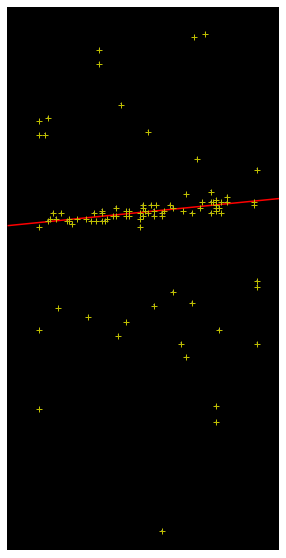

In [19]:
NUM_ITER = 100       # number of RANSAC iterations
INLIER_THRESH = 20  # threshold distance for outliers 

# Initialize best consensus set (tuple of indices within x (and y))
best_consensus_set = np.zeros((0,))

# Number of data points
numpts=x.size

# Try many lines, and keep the consensus set of the best line
for iter in range(NUM_ITER):
    
    # Randomly sample two points (note: option ensures points are distinct)
    sample_inds = np.random.choice(numpts,size=2,replace=False)
    xs = x[sample_inds]
    ys = y[sample_inds]

    # Make homogeneous, and determine line using cross product
    p1 = np.array([xs[0], ys[0], 1], dtype=np.float32)
    p2 = np.array([xs[1], ys[1], 1], dtype=np.float32)
    line = np.cross(p1, p2)
    
    # Compute perpendicular distance from line to every datapoint,
    #    storing results in vector `dist` of size = numpts

    # YOUR CODE HERE #

    A = line[0]
    B = line[1]
    
    dist = np.abs(np.dot(x0y01, line.reshape(3,1))) / np.sqrt(A**2 + B**2)
    # Find consensus set (tuple of indices within x (and y))
    consensus_set = np.nonzero(dist < INLIER_THRESH)[0]

    # If it is larger than the best one so far, keep it
    if consensus_set.size < best_consensus_set.size:
        continue
    best_consensus_set = consensus_set

# inliers for best line
xc = x[best_consensus_set]
yc = y[best_consensus_set]

# fit final line to these inliers
l=fitlineTLS(np.vstack((xc, yc)).T)

# plot image, points, and line
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(img,cmap="gray")
ax.axis('off')

plt.plot(x, y, 'y+')

h,w=img.shape
plotimageline(h,w,l,ax)